In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from researchai.layers import Dense
from researchai.commons import Softmax_CategoricalCrossentropy
from researchai.metrics import classification_accuracy
from researchai.optimizers import SGD
from researchai.utils import one_hot

In [2]:
data_path = Path("../data")

In [3]:
df = pd.read_csv(data_path / "names.txt", names=["Name"])
df.head(10)

,Name
0,emma
1,olivia
2,ava
3,isabella
4,sophia
5,charlotte
6,mia
7,amelia
8,harper
9,evelyn


In [4]:
df.describe()

,Name
count,32033
unique,29494
top,emma
freq,2


In [5]:
# We have some duplicates 
df['Name'] = df['Name'].str.lower()
df.drop_duplicates(subset=['Name'], keep='first', inplace=True)

df.describe()

,Name
count,29494
unique,29494
top,emma
freq,1


In [6]:
df.head(10)

,Name
0,emma
1,olivia
2,ava
3,isabella
4,sophia
5,charlotte
6,mia
7,amelia
8,harper
9,evelyn


## mininum and maximum length of the words

In [7]:
df["Length"] = df["Name"].apply(lambda s: len(s))
df.head(10)

,Name,Length
0,emma,4
1,olivia,6
2,ava,3
3,isabella,8
4,sophia,6
5,charlotte,9
6,mia,3
7,amelia,6
8,harper,6
9,evelyn,6


In [8]:
df.sort_values(by=["Length"], ascending=False)

,Name,Length
31441,muhammadibrahim,15
31442,muhammadmustafa,15
30197,alexanderjames,14
29637,michaelanthony,14
12005,mariaguadalupe,14
...,...,...
24160,jd,2
10930,kc,2
24159,jc,2
23151,dj,2


# Probabilistic model

In [9]:
# '<S>' and '<E>' are start and end tokens

bigrams = {}
for w in df["Name"]:
    chars = ['<S>'] + list(w) + ['<E>']
    for char1, char2 in zip(chars, chars[1:]):
        bigram = (char1, char2)
        bigrams[bigram] = bigrams.get(bigram, 0) + 1

In [10]:
sorted(bigrams.items(), key=lambda kv: -kv[1])

[(('a', '<E>'), 6474),
 (('n', '<E>'), 6003),
 (('a', 'n'), 5093),
 (('<S>', 'a'), 4131),
 (('e', '<E>'), 3641),
 (('e', 'l'), 3073),
 (('a', 'r'), 3009),
 (('n', 'a'), 2910),
 (('r', 'i'), 2761),
 (('<S>', 'k'), 2689),
 (('l', 'e'), 2677),
 (('l', 'a'), 2473),
 (('m', 'a'), 2427),
 (('a', 'l'), 2417),
 (('e', 'n'), 2402),
 (('<S>', 'm'), 2375),
 (('l', 'i'), 2346),
 (('i', 'a'), 2335),
 (('h', '<E>'), 2304),
 (('a', 'h'), 2240),
 (('r', 'a'), 2229),
 (('<S>', 'j'), 2221),
 (('i', '<E>'), 2218),
 (('o', 'n'), 2199),
 (('h', 'a'), 2097),
 (('y', 'a'), 2074),
 (('i', 'n'), 1946),
 (('<S>', 's'), 1899),
 (('a', 'y'), 1894),
 (('n', 'n'), 1807),
 (('e', 'r'), 1761),
 (('y', '<E>'), 1725),
 (('y', 'n'), 1632),
 (('n', 'i'), 1598),
 (('k', 'a'), 1596),
 (('<S>', 'd'), 1571),
 (('a', 'i'), 1541),
 (('r', 'e'), 1540),
 (('i', 'e'), 1537),
 (('a', 'm'), 1506),
 (('l', 'y'), 1477),
 (('<S>', 'r'), 1458),
 (('<S>', 'l'), 1446),
 (('<S>', 'e'), 1430),
 (('<S>', 'c'), 1387),
 (('j', 'a'), 1371),
 (

In [11]:
# Loop up tables 
chars = sorted(set("".join(df["Name"].to_list()))) + ['<S>'] + ['<E>']

stoi = {char:i for i, char in enumerate(chars)}
itos = {i:chars for chars, i in stoi.items()}
itos

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'j',
 10: 'k',
 11: 'l',
 12: 'm',
 13: 'n',
 14: 'o',
 15: 'p',
 16: 'q',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'x',
 24: 'y',
 25: 'z',
 26: '<S>',
 27: '<E>'}

In [12]:
counts_array = np.zeros((28, 28), dtype=np.int64) + 1 # model smoothing
for w in df["Name"]:
    chars = ['<S>'] + list(w) + ['<E>']
    for char1, char2 in zip(chars, chars[1:]):
        idx1 = stoi[char1]
        idx2 = stoi[char2]

        counts_array[idx1, idx2] += 1

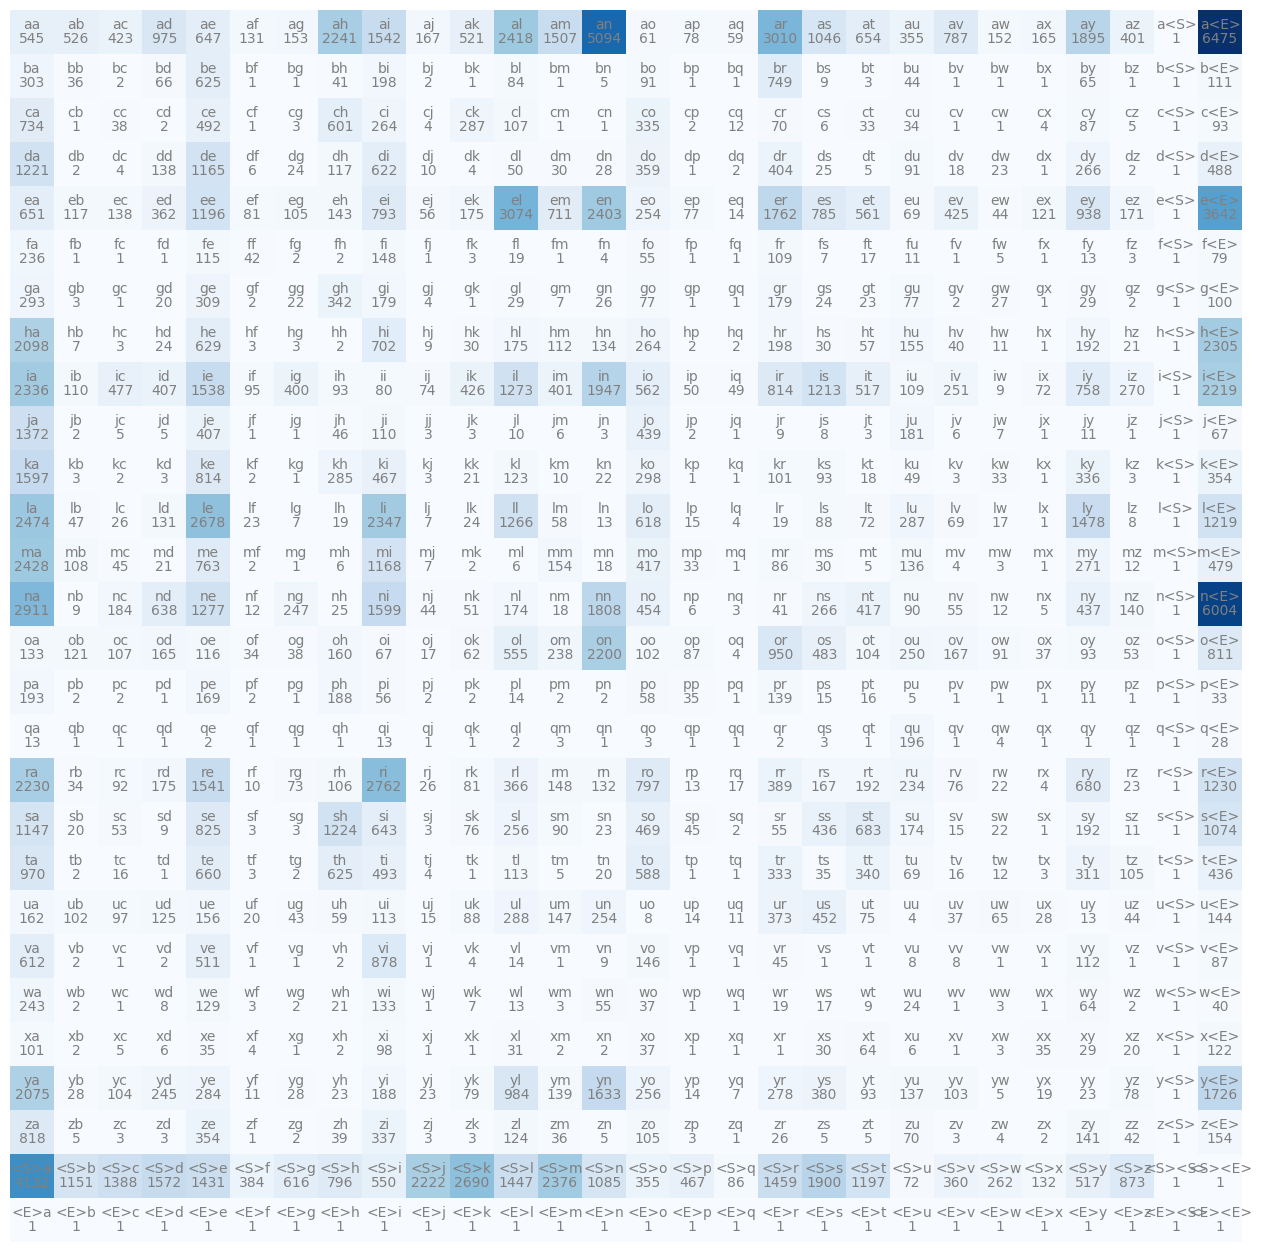

In [13]:
plt.figure(figsize=(16,16))
plt.imshow(counts_array, cmap='Blues')
for i in range(28):
    for j in range(28):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, counts_array[i, j], ha="center", va="top", color='gray')
plt.axis('off')
plt.show()

In [14]:
# probability_matrix = np.full_like(probability_matrix, fill_value=1/27)
probability_matrix = counts_array / counts_array.sum(axis=-1, keepdims=True) # probabilistic model

### Inference

In [15]:
for i in range(20):
    idx = 26
    chars = []
    while True:
        chars.append(itos[idx])
        
        if idx == 27:
            break

        probs = probability_matrix[idx]
        idx = np.random.multinomial(1, probs).argmax()


    print(''.join(chars))

<S>dyn<E>
<S>ldunavee<E>
<S>shaken<E>
<S>novydilirsa<E>
<S>a<E>
<S>khilfridan<E>
<S>a<E>
<S>jay<E>
<S>a<E>
<S>andedienertolon<E>
<S><S>kaielelin<E>
<S>lapaphanaen<E>
<S>bren<E>
<S>leiy<E>
<S>n<E>
<S>bahah<E>
<S>gridieobaien<E>
<S>y<E>
<S>meeadryen<E>
<S>steri<E>


### Train Loss

In [16]:
loss = 0.0
num_samples = 0
for w in df["Name"]:
    chars = ['<S>'] + list(w) + ['<E>']
    for char1, char2 in zip(chars, chars[1:]):
        idx1 = stoi[char1]
        idx2 = stoi[char2]

        probability = probability_matrix[idx1, idx2]
        loss += -np.log(probability)
        num_samples += 1

# Normilize loss
loss = loss / num_samples
print(f"Train loss: {loss:.3f}")

Train loss: 2.454


# Neural Network approch

In [17]:
X, y = [], []
for w in df["Name"]:
    chars = ['<S>'] + list(w) + ['<E>']
    for char1, char2 in zip(chars, chars[1:]):
        idx1 = stoi[char1]
        idx2 = stoi[char2]

        X.append(idx1)
        y.append(idx2)

X = np.array(X)
y = np.array(y)

In [18]:
X = one_hot(X, num_classes=28)

In [19]:
layer1 = Dense(28, 28)
softmax_cross_entropy = Softmax_CategoricalCrossentropy()

optimizer = SGD()

losses = []
accuracies = []
for epoch in range(1, 101):
    # forward
    layer1.forward(X)
    softmax_cross_entropy.forward(layer1.outputs, y)

    loss = softmax_cross_entropy.loss
    acc = classification_accuracy(softmax_cross_entropy.outputs, y)

    # stats
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.3f}, Acc: {acc:.3f}")

    # log
    losses.append(loss)
    accuracies.append(acc)

    # early stopping
    if loss <= 2.454:
        print("Early Stopping, reached desired loss.")
        break

    # backward
    softmax_cross_entropy.backward()
    layer1.backward(softmax_cross_entropy.inputs_grad)

    # update params
    optimizer.step(layer1)


Epoch: 10, Loss: 3.022, Acc: 0.208
Epoch: 20, Loss: 2.882, Acc: 0.208
Epoch: 30, Loss: 2.817, Acc: 0.208
Epoch: 40, Loss: 2.777, Acc: 0.208
Epoch: 50, Loss: 2.747, Acc: 0.208
Epoch: 60, Loss: 2.724, Acc: 0.208
Epoch: 70, Loss: 2.705, Acc: 0.208
Epoch: 80, Loss: 2.689, Acc: 0.218
Epoch: 90, Loss: 2.675, Acc: 0.218
Epoch: 100, Loss: 2.663, Acc: 0.218


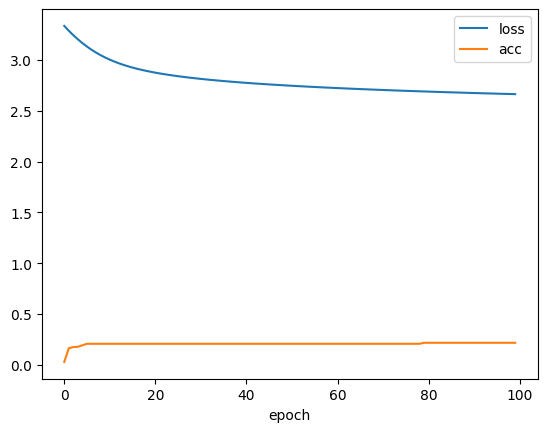

In [20]:
plt.plot(losses, label='loss')
plt.plot(accuracies, label='acc')
plt.xlabel("epoch")

plt.legend()
plt.show()

In [29]:
# Sample for neural network model
pretty_print = True
for i in range(20):
    idx = 26
    chars = []
    while True:
        # forward
        chars.append(itos[idx])
        if idx == 27:
            break

        inputs = one_hot(np.array([idx]), num_classes=28)
        layer1.forward(inputs)
        softmax_cross_entropy.forward(layer1.outputs, y[idx].reshape(-1, 1))
        
        probs = softmax_cross_entropy.outputs.reshape(-1)
        idx = np.random.multinomial(1, probs).argmax()

    if pretty_print:
        print("".join(chars[1:-1]))
    else:
        print(''.join(chars))

hdrinegia
j

asmaureahr
kkels
msirea
ca
asrih
einszyaianshaw

anan
fehn
gzla
jnilayah
ken
sin<S>g
oi
jolaeliu

o


c:\Dev\GenChars\.venv\lib\site-packages\researchai\losses.py:69: RuntimeWarning: divide by zero encountered in log
  neg_logs = -np.log(correct_confidences)


## Damn Bigram language models are terrible